In [ ]:
# menyiapkan seluruh library yang diperlukan
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD, Adam, Adamax

In [ ]:
# mengekstrak data dari file zip ke colab
zip_path = '/content/drive/My\ Drive/abc/santa-dataset.zip'

!cp {zip_path} /content/

!cd /content/

!unzip -q /content/santa-dataset.zip -d /content

!rm /content/santa-dataset.zip

In [ ]:
# membagi data train dan validation
dasar_dir = '/content/santa-dataset/'
training_dir = os.path.join(dasar_dir, 'train')
validation_dir = os.path.join(dasar_dir, 'test')

In [ ]:
# menentukan hyperparameter image augmentation
datagen = ImageDataGenerator(rescale=1./255, 
                            shear_range=0.2, 
                            rotation_range=20, 
                            horizontal_flip=True, 
                            fill_mode='nearest')

In [ ]:
# melakukan image augmentation pada data train dan validation
train_iterator = datagen.flow_from_directory(training_dir,
                                             class_mode='binary', 
                                             batch_size=32,
                                             target_size=(200, 200))

val_iterator = datagen.flow_from_directory(validation_dir,
                                           class_mode='binary',
                                           batch_size=32,
                                           target_size=(200, 200))

Found 662 images belonging to 2 classes.
Found 260 images belonging to 2 classes.


In [ ]:
# membuat arsitektur model
cnn_model = Sequential()

cnn_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', 
                     padding='same', input_shape=(200, 200, 3)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform',
                     padding='same'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform',
                     padding='same'))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='sigmoid'))

opt = Adam(lr=0.0001)

cnn_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10, mode='max')

cnn_model.summary()

history = cnn_model.fit(train_iterator,
                       steps_per_epoch=len(train_iterator),
                       callbacks=[callback],
                       validation_data=val_iterator,
                       validation_steps=len(val_iterator),
                       epochs=60)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 25, 25, 128)       0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 80000)           

In [ ]:
history_dataframe = pd.DataFrame(history.history)
history_dataframe['epoch'] = history.epoch
history_dataframe.sort_values(by='val_accuracy', ascending=False)[:3]

,loss,accuracy,val_loss,val_accuracy,epoch
29,0.053248,0.984894,0.248076,0.942308,29
36,0.040930,0.983384,0.297289,0.938462,36
30,0.052598,0.981873,0.268104,0.934615,30


In [ ]:
accuracy, loss = cnn_model.evaluate(val_iterator)

9/9 [==============================] - 5s 610ms/step - loss: 0.2763 - accuracy: 0.9308


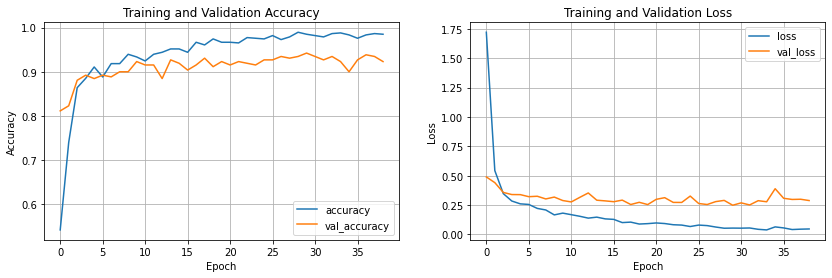

In [ ]:
# membuat grafi Accuracy dan Loss
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
# plt.ylim([0.0, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
# plt.ylim([0.0, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

Saving was.jfif to was (8).jfif
was.jfif


Saving download.jfif to download (5).jfif
download.jfif


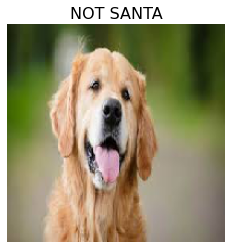

In [ ]:
# melakukan prediksi gambar dari gambar online
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



uploaded = files.upload()

for fn in uploaded.keys():
 
  # memprediksi gambar
  path = fn
  img = image.load_img(path, target_size=(200,200))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = cnn_model.predict(images, batch_size=10)
  
  print(fn)
  if classes == 0:
    nama = 'NOT SANTA'
  elif classes == 1:
    nama = 'SANTA'

  plt.title(nama, size=16)
  plt.axis(False)

## Penjelasan:
- **EDA**: Dataset berupa gambar/photo yang dikategorikan 2 label yaitu Gambar Santa dan Not Santa (gambar campuran selain Santa), jumlah data training 662 gambar (331 Santa dan 331 not Santa) dan data validation 260 gambar (130 santa dan 130 not ssanta), memiliki ukuran pixel yang beragam mulai dari ratusan hingga ribuan serta ukuran size yang berbeda, gambar dengan label Santa didominasi gambar foto manusia asli maupun cartoon dengan dominasi warna merah dan janggut putih sedangkan gambar dengan label not Santa didominasi gambar dan warna yang beraneka ragam.
- **Preprocessing**: Pada tahap ini dilakukan image augmentation dengan parameter pergeseran, rotasi, dan bolak balik gambar, ukuran batch yang digunakan 32 karena jumlah data tidak terlalu banyak dan ukuran target ditetapkan 200x200 pixel karena gambar didominasi ukururan pixel ratusan serta juga agar tidak melebihi ukuran pixel gambar yang berukuran ribuan.
- **Model Selction**: Model arsitektur yang dipakai yaitu Deeper CNN dengan 3 layer konvolusi (32, 64, 128 kernel 3x3) dengan maxpooling pada masing-masing layer konvolusi, optimizer memakai Adam dengan lr = 0.0001 agar pergerakan perubahan nilai loss atau accuracy kecil per epochnya, metode loss = binary crossentropy karena label atau kategori data dua jenis, serta saya memakai fungsi callback agar iterasi epochnya akan berhenti sendiri jika nilai akurasi dalam beberapa epoch terakhir kontan meskipun belum menyelesaikan epoch yang ditentukan.
- **Model Evaluation**: Dari model arsitektur yang diterapkan diperoleh sweetspot pada val_accuracy = 0.94 dan val_loss = 0.24 di epoch 29. Berdasarkan perbandingan loss dan accuracy pada data training dan validation hasil prediksi sudah lumayan bagus dengan peningkatan dan penurunan loss dengan berjalannya epoch meskipun belum sempurna karena masih terdapat variance baik di accuracy maupun loss namun tidak begitu besar. Saat dicoba memprediksi gambar dari gambar yang diambil dari internet, hasil prediksinya sudah lumayan bagus karena sudah dapat membedakan santa maupun not santa seperti contoh gambar anjing diprediksi sebagai not santa.